In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from difflib import get_close_matches
from IPython.display import display
from matplotlib.ticker import ScalarFormatter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import statistics

## Preprocessing & data cleaning

**steps include:**
- renaming dataset columns to snake_case and english
- checking for missing values
- checking for potential outliers
- adding column country 
- validating text data
- converting date to integer

In [2]:
df = pd.read_csv("fotbal_prestupy_2000_2019.csv", encoding="utf-8")

In [3]:
df.head()

,Jméno,Pozice,Věk,Původní tým,Původní liga,Nový tým,Nová Liga,Sezóna,Odhadovaná hodnota,Přestupová částka
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000


In [62]:
df.shape

(4700, 12)

In [4]:
df.rename(columns={"Jméno": "name", 
                   "Pozice": "position", 
                   "Věk": "age", 
                   "Původní tým": "original_team", 
                   "Původní liga": "original_league",
                   "Nový tým": "new_team",
                   "Nová  Liga": "new_league",
                   "Sezóna": "season",
                   "Odhadovaná hodnota": "estimated_value",
                   "Přestupová částka": "transfer_fee"}, inplace=True)
df.head()

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000


## Understanding the dataset

From limited information about the data, some research had to be done to understand and correctly interpret data. Based on empirical evidence, transfer_fee and estimated_value are both in €. For the sake of readability, I will divide those columns by 1000, making it estimated and true value of the player in thousands of euros. 

In [5]:
df["transfer_fee"] = df["transfer_fee"]/1000
df["estimated_value"] = df["estimated_value"]/1000

### Validating text columns 
First I want to check all the text columns and try to find possible typos which could lead to duplicities. For this I will use difflib function get_close_matches, which will be able to return similar enough cases and should cover typos and mistranslations. 

In [6]:
text_cols = ["name", "position", "original_team", "original_league", "new_team", "new_league"]

def preprocess_text(column):
    column = column.str.strip() # strip trailing spaces 
    column = column.str.replace("-"," ") # replace - with space
    column = column.str.replace("\n","") # remove newlines
    column = column.str.replace("\t","") # remove tabs
    column = column.str.lower() # all lowercase
    return column

In [7]:
for col in text_cols:
    df[col] = preprocess_text(df[col])

In [8]:
def get_similar_entities(unique_names):
    matches= []
    for i, name in enumerate(list(unique_names)):
        possible_match = get_close_matches(name, list(unique_names[i+1:]), cutoff=0.7)
        if possible_match:
            matches.append((name, possible_match))
    return matches

In [9]:
for col in ["team", "league"]:
    display(f"Similarities for {col}s:")
    display(get_similar_entities(pd.concat([df[f"original_{col}"], df[f"new_{col}"]]).unique()))

'Similarities for teams:'

[('fc barcelona', ['fc barcelona b', 'barcelona sc', 'fc basel']),
 ('parma', ['paraná']),
 ('arsenal', ['arsenal fc', 'arsenal u23', 'arsenal u18']),
 ('real madrid', ['real murcia']),
 ('west ham', ['west brom']),
 ('monaco', ['monza']),
 ('valencia cf', ['valencia b']),
 ('atlético madrid', ['atlético pr', 'atlético mg']),
 ('atlético pr', ['atlético mg']),
 ('chelsea', ['chelsea u23']),
 ('inter', ['inter u19']),
 ('benfica', ['benfica b', 'benfica u19']),
 ('sparta praha', ['sparta r.']),
 ('partizan', ['paraná']),
 ('sporting cp', ['sporting gijón']),
 ('são paulo', ['fc são paulo b']),
 ('racing', ['reading', 'racing club']),
 ('lens', ['león', 'le mans']),
 ('mk dons', ['mk dons u18']),
 ('internacional', ['nacional', 'ternana']),
 ('dinamo zagreb', ['nk zagreb', 'dinamo bukarest']),
 ('olympiacos', ['olimpia']),
 ('bolton', ['bologna']),
 ('juventus', ['juventude']),
 ('rangers', ['sco angers']),
 ('nacional', ['atl. nacional']),
 ('loko moscow', ['cska moscow', 'torpedo mosco

'Similarities for leagues:'

[('laliga', ['laliga2']),
 ('serie a', ['série a', 'serie b', 'serie c   a']),
 ('premier league', ['u18 premier league', 'super league', 'premier liga']),
 ('ligue 1', ['ligue 2', 'liga 1', 'rel. ligue 1']),
 ('serie b', ['série b', 'serie c   b', 'série a']),
 ('1.bundesliga', ['2.bundesliga', 'bundesliga']),
 ('liga nos', ['liga 1']),
 ('eredivisie', ['u19 eredivisie']),
 ('england', ['finland']),
 ('süper lig', ['superliga', 'superligaen']),
 ('croatia', ['romania']),
 ('super league',
  ['stars league', 'u18 premier league', 'jupiler pro league']),
 ('2.bundesliga', ['bundesliga']),
 ('1.lig', ['3.liga']),
 ('k league 1', ['j2 league', 'j1 league', 'league one']),
 ('serie c   a', ['serie c   b']),
 ('série a', ['série b']),
 ('superligaen', ['superliga']),
 ('j1 league', ['j2 league']),
 ('torneo final', ['torneo inicial']),
 ('2ª b   grupo iii', ['2ª b   grupo i']),
 ('liga mx clausura', ['liga mx apertura']),
 ('liga 1   championship group',
  ['a grupa   championship gr.', 'su

### Text cols revision results:
**Revision of close matches found out two mistakes:**
Al Shabab was in several instances named just Shabab
Al Nasr was in several instances named just Nasr

In [10]:
df.loc[df["original_team"] == "shabab", "original_team"] = "al shabab"
df.loc[df["new_team"] == "shabab", "original_team"] = "al shabab"

df.loc[df["original_team"] == "nasr", "original_team"] = "al nasr"
df.loc[df["new_team"] == "nasr", "new_team"] = "al nasr"

## Validating other columns 
looking into season, age, estimated_value and transfer_fee columns

In [11]:
df["season"] = df["season"].str.split("-", expand=True)[0] # take the starting year of season
df["season"] = df["season"].astype(int)

### Check validity of ages 

In [12]:
df["age"].sort_values(ascending=True) # There is one player who is 0 years old

236      0
1370    15
945     16
4502    16
1306    16
        ..
439     34
112     35
2954    35
487     35
2414    35
Name: age, Length: 4700, dtype: int64

There is one player with age 0. Assuming his parents did not sell his soul to a Saudi Arabian football club, I will impute this value with information available online. If there were more cases than just 1 and imputing with real data was too time consuming or impossible, I would use mean or median imputation. 

From his wikipedia page, I can see that he was 25 years old during his transfer from al shabab to ittihad

In [13]:
df[df["age"] == 0]

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee
236,marzouq al otaibi,centre forward,0,al shabab,saudi arabia,ittihad,saudi arabia,2000,NaN,2000.0


In [14]:
df.loc[df["age"] == 0, "age"] = 25

In [15]:
df["age"].isna().sum() 

0

### Check validity of season
The number and values of seasons matches. No validation to go through here.

In [16]:
df["season"].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

### Check validity of transfer_fee


In [17]:
df["transfer_fee"].isna().sum() # no missing values

0

In [18]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,age,season,estimated_value,transfer_fee
count,4700.00,4700.00,3440.00,4700.00
mean,24.34,2009.00,8622.47,9447.59
std,3.21,5.47,8795.18,10437.72
min,15.00,2000.00,50.00,825.00
25%,22.00,2004.00,3500.00,4000.00
50%,24.00,2009.00,6000.00,6500.00
75%,27.00,2014.00,10000.00,10820.00
max,35.00,2018.00,120000.00,222000.00


### Check validity of estimated_value

In [19]:
df[df.isna().any(axis=1)] #1260 missing values -> all of them are in estimated_value 

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee
0,luís figo,right winger,27,fc barcelona,laliga,real madrid,laliga,2000,NaN,60000.0
1,hernán crespo,centre forward,25,parma,serie a,lazio,serie a,2000,NaN,56810.0
2,marc overmars,left winger,27,arsenal,premier league,fc barcelona,laliga,2000,NaN,40000.0
3,gabriel batistuta,centre forward,31,fiorentina,serie a,as roma,serie a,2000,NaN,36150.0
4,nicolas anelka,centre forward,21,real madrid,laliga,paris sg,ligue 1,2000,NaN,34500.0
...,...,...,...,...,...,...,...,...,...,...
4355,douglas luiz,central midfield,19,vasco da gama,série a,man city,premier league,2017,NaN,12000.0
4427,jadon sancho,left winger,17,man city u18,u18 premier league,bor. dortmund,1.bundesliga,2017,NaN,7840.0
4618,davide bettella,centre back,18,inter,serie a,atalanta,serie a,2018,NaN,7000.0
4648,william bianda,centre back,18,lens,ligue 2,as roma,serie a,2018,NaN,6000.0


There are missing values across all the years except 2015. 
Most of  them in 2000, 2001, 2002, 2003, 2004.

Possible solutions: 
   - Dropping the values
   - mean/median imputation 
   - regression imputation

In [20]:
df[df.isna().any(axis=1)]["season"].value_counts() 

season
2001    250
2000    248
2002    244
2003    242
2004    189
2005     28
2006     20
2007     13
2008      7
2010      4
2017      3
2018      3
2012      2
2013      2
2009      2
2014      1
2016      1
2011      1
Name: count, dtype: int64

### Deriving feature country - this is me trying to be original
**While league and team may be useful identificators of the background, it may not always be clear where the team is from as we have 615 unique teams. I decided to engineer a features "origin_country" and "target_country", that will represent the countries of the original and target teams, respectively.**

**For this I decided to use GPT 3.5 from OpenAI with the prompt:**
*"You will be presented with a list of football teams. I want you to assign the country of origin to them. Provide me with an output in the form of a python dictionary. E.g. {"Chelsea": "England", "Bayern": "Germany"}. If you are not sure what country the team is from, type "unknown"."*


**Outputs from the language model were saved into *countries.json* file.** 

In [21]:
pd.concat([df["original_team"], df["new_team"]]).unique()  # output from this list was used in the prompt to generate the feature country

array(['fc barcelona', 'parma', 'arsenal', 'fiorentina', 'real madrid',
       'west ham', 'dep. la coruña', 'real zaragoza', 'monaco',
       'valencia cf', 'atlético madrid', 'atlético pr', 'river plate',
       'boca juniors', 'stade rennais', 'coventry city',
       'cagliari calcio', 'bay. leverkusen', 'chelsea', 'dynamo kyiv',
       'inter', 'rcd mallorca', 'g. bordeaux', 'fc porto', 'benfica',
       'lazio', 'real betis', 'everton', 'sparta praha', 'málaga cf',
       'partizan', 'celta de vigo', 'sporting cp', 'aston villa',
       'afc ajax', 'são paulo', 'marseille', 'racing', 'lens', 'mk dons',
       'cd tenerife', 'norwich', 'celtic', 'fenerbahce', 'middlesbrough',
       'internacional', 'leicester', 'rosenborg bk', 'dinamo zagreb',
       'feyenoord', 'grasshoppers', 'olympiacos', 'bolton', 'reggina',
       'juventus', 'fluminense', 'lecce', 'liverpool', 'cd cruz azul',
       'u. de chile', 'ponte preta', 'vitesse', 'galatasaray',
       'montpellier', 'roda jc', 're

In [22]:
with open("countries.json", "r", encoding="utf-8") as f:
    countries = json.load(f)

In [23]:
df_countries = pd.DataFrame.from_dict(countries.items())
df_countries.columns =["team", "country"]
df_countries["team"] = preprocess_text(df_countries["team"])
df_countries["country"] = preprocess_text(df_countries["country"])

In [24]:
df = pd.merge(df, df_countries, left_on=["new_team"], right_on=["team"], how="left")
df = pd.merge(df, df_countries, left_on=["original_team"], right_on=["team"], how="left", suffixes=("_new", "_original"))
df.drop(["team_new", "team_original"], axis=1, inplace=True)
df.rename(columns={"country_new": "new_country", "country_original": "original_country"}, inplace=True)

In [25]:
# Welsh teams can play in welsh and english leagues. Welsh teams playing in premier or championship leagues will be labeled as english for the sake of simplicity.
df.loc[(df["new_country"] == "wales") & ((df["new_league"] == "premier league") | (df["new_league"] == "championship")) , "new_country"] = "england"
df.loc[(df["original_country"] == "wales") & ((df["original_country"] == "premier league") | (df["original_country"] == "championship")) , "new_country"] = "england"

### Outliers 
Checking for outliers is useful, as their presence could negatively affect models/statistical analysis etc. 
However due to this being only EDA task, while identifying and storing outliers, I will not remove them nor take any measures. On the contrary, I find them quite interesting to look at -> they could give us more insight into why these players are so expensive.
The main idea being not removing outliers from this dataset is that it is NOT randomly sampled - we are sampling the 250 most expensive football transfers in the year, it is natural that we get some extreme values that  all others. 

In [26]:
def get_outliers_iqr(df, column_name):
    sns.set_palette("turbo")
    fig, ax = plt.subplots(figsize=(10, 6))
    boxplot = ax.boxplot(df[column_name], vert=False, patch_artist=True)

    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    lower_bound_ex = q1 - 3 * iqr
    upper_bound_ex = q3 + 3 * iqr

    outliers = df[((df[column_name] < lower_bound) & (df[column_name] >= lower_bound_ex)) | (
            (df[column_name] > upper_bound) & (df[column_name] <= upper_bound_ex))]
    ext_outliers = df[(df[column_name] < lower_bound_ex) | (df[column_name] > upper_bound_ex)]

    ax.scatter(outliers[column_name], [1] * len(outliers),  alpha=0.7, label="Outliers", s=15, marker="o")
    ax.scatter(ext_outliers[column_name], [1] * len(ext_outliers), alpha=0.7, label="Extreme Outliers", s=20, marker="x")

    ax.axvline(lower_bound_ex, color="orange", linestyle="--", label="Lower Bound (3*IQR)")
    ax.axvline(upper_bound_ex, color="orange", linestyle="--", label="Upper Bound (3*IQR)")

    ax.set_yticklabels([column_name])
    ax.set_xlabel("Values")
    ax.set_title(f"Boxplot for {column_name} with Outliers")

    ax.legend()

    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    plt.show()
    return outliers, ext_outliers
    

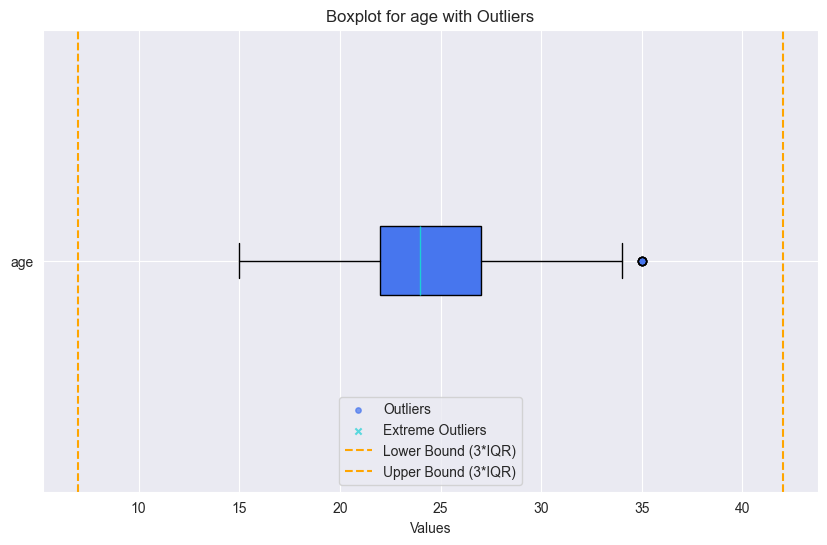

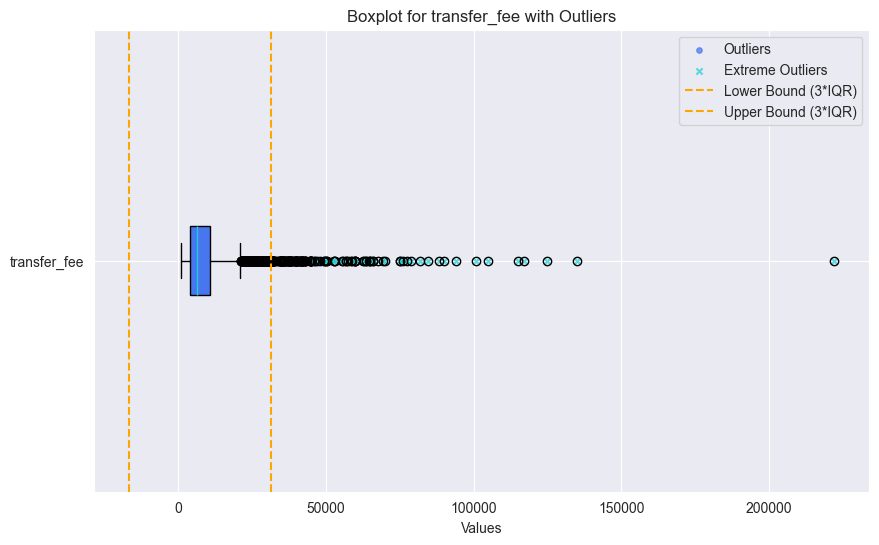

In [57]:
age_outl, _ = get_outliers_iqr(df, "age")
outliers, ext_outliers = get_outliers_iqr(df, "transfer_fee")

In [58]:
age_outl

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee,new_country,original_country
112,josé luis chilavert,goalkeeper,35,vélez sarsfield,argentina,r. strasbourg,ligue 1,2000,5098.562390,5300.0,france,argentina
487,claudio taffarel,goalkeeper,35,galatasaray,süper lig,parma,serie a,2001,2959.907537,2000.0,italy,turkey
2414,zé roberto,left midfield,35,nacional,primera división,hamburger sv,1.bundesliga,2009,5000.000000,4000.0,germany,uruguay
2954,shay given,goalkeeper,35,man city,premier league,aston villa,premier league,2011,5500.000000,3750.0,england,england


In [28]:
ext_outliers.sort_values(by=["transfer_fee"], ascending=False)

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee,new_country,original_country
4211,neymar,left winger,25,fc barcelona,laliga,paris sg,ligue 1,2017,100000.0,222000.0,france,spain
4455,kylian mbappé,right winger,19,monaco,ligue 1,paris sg,ligue 1,2018,120000.0,135000.0,france,france
4212,philippe coutinho,attacking midfield,25,liverpool,premier league,fc barcelona,laliga,2017,90000.0,125000.0,spain,england
4456,cristiano ronaldo,centre forward,33,real madrid,laliga,juventus,serie a,2018,100000.0,117000.0,italy,spain
4213,ousmane dembélé,right winger,20,bor. dortmund,1.bundesliga,fc barcelona,laliga,2017,33000.0,115000.0,spain,germany
...,...,...,...,...,...,...,...,...,...,...,...,...
2976,oscar,attacking midfield,20,internacional,série a,chelsea,premier league,2012,20000.0,32000.0,england,brazil
3730,danilo,right back,23,fc porto,liga nos,real madrid,laliga,2015,25000.0,31500.0,spain,portugal
1233,shaun wright phillips,right winger,23,man city,premier league,chelsea,premier league,2005,9500.0,31500.0,england,england
1730,anderson,central midfield,19,fc porto,liga nos,man utd,premier league,2007,25000.0,31500.0,england,portugal


### Imputing missing values

For handling missing values I decided to go with regression imputation. Imputing with mean or median values for estimated_value column would make little to no sense as there clearly is a correlation between the *estimated_value* and *transfer_fee* and we should account for that. I decided to go with a simple model with only one explanatory variable and that being *transfer_fee*. Other values such as the player position could be added for more complex model. Needless to say, with R^2 ~ 0.73, the model does a sufficiently good job at imputing the missing values. I *could* remove the outliers from this model, but since I am not using them anywhere, I will skip this step as it will save me some time. 

R-squared (R2): 0.7295
Mean Squared Error (MSE): 19787873.6186
Root Mean Squared Error (RMSE): 4448.3563


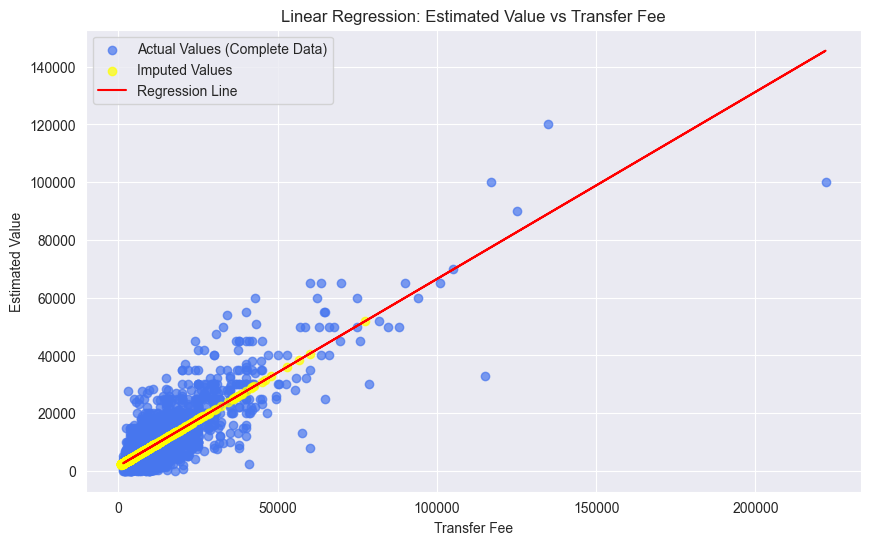

In [29]:
df_copy = pd.get_dummies(df, columns=["position"])
df_complete = df_copy.dropna(subset=["estimated_value"])
df_incomplete = df_copy[df_copy["estimated_value"].isnull()]

X_cols = ["transfer_fee"]

X = df_complete[X_cols]
y = df_complete["estimated_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
sns.set_palette("turbo")

plt.figure(figsize=(10, 6))

plt.scatter(df_complete["transfer_fee"], y, alpha=0.7, label="Actual Values (Complete Data)")
plt.scatter(df_incomplete["transfer_fee"], model.predict(df_incomplete[X_cols]), color = "yellow", alpha=0.7, label="Imputed Values")
plt.plot(df_complete["transfer_fee"], model.predict(X), color="red", label="Regression Line")

plt.title("Linear Regression: Estimated Value vs Transfer Fee")
plt.xlabel("Transfer Fee")
plt.ylabel("Estimated Value")
plt.legend()
plt.show()
df.loc[df["estimated_value"].isnull(), "estimated_value"] = model.predict(df_incomplete[X_cols])

# Analysis of the dataset
## 1. Basic analysis
First we should take a closer look at some basic statistical facts in the dataset. This will help us possibly derive more information as we move forward. We already know some basic info about outlying values and missing values. 

In [30]:
def get_hist(df,col,msg=""):
    sns.set_palette("turbo")
    plt.hist(df[col], bins=20, edgecolor="black")
    plt.title(f"Distribution of values in {col} {msg}:")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
    
    print(f"Mean value of '{col}' {msg}: {np.mean(df[col])}")
    print(f"Median value of '{col}' {msg}: {np.median(df[col])}")
    print(f"Variance value of '{col}' {msg}: {np.var(df[col])}")
    print(f"1st quartile value of '{col}' {msg}: {df[col].quantile(0.25)}")
    print(f"3rd quartile value of '{col}' {msg}: {df[col].quantile(0.75)}")

def get_relative_freq_categorical(df, col):
    position_counts = df[col].value_counts(normalize=True, sort=True)

    sns.set_palette("turbo")

    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    bar_plot = sns.barplot(x=position_counts.index, y=position_counts.values)

    plt.xlabel(col)
    plt.ylabel("Relative Frequency")
    plt.title(f"Relative Frequencies of {col}")

    # plt.xticks(rotation=45, ha='right')
    plt.xticks(rotation=90)

    for p in bar_plot.patches:
        bar_plot.annotate(f'{p.get_height()*100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha="center", va="center", xytext=(0, 25), textcoords="offset points", rotation = 90)

    # Show the plot
    plt.tight_layout()
    plt.show()

def plot_popular_destinations(df, dest, top_n):
    country_counts = df.groupby(["season", dest]).size().reset_index(name="counts")
    season_totals = country_counts.groupby("season")["counts"].sum().reset_index(name="total_appearances")

    country_counts = pd.merge(country_counts, season_totals, on="season", how="left")
    country_counts["proportion"] = country_counts["counts"] / country_counts["total_appearances"]

    top_countries = country_counts.groupby(dest)["proportion"].sum().nlargest(top_n).index

    top_countries_data = country_counts[country_counts[dest].isin(top_countries)]

    pivot_data = top_countries_data.pivot(index="season", columns=dest, values="proportion").fillna(0)

    plt.figure(figsize=(10, 6))
    for country in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[country], label=country, marker="o")

    plt.title(f"Top {top_n} Most Frequent {dest} (Proportional) Over the Years")
    plt.xlabel("Season")
    plt.ylabel("Proportion of Appearances")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.xticks(pivot_data.index[pivot_data.index % 1 == 0].astype(int))

    plt.grid(True)
    plt.show()

def median_price_per_player(df, col):
    sorted_positions = df.groupby(col)["transfer_fee"].median().sort_values(ascending=False).index
    # Create a boxplot using seaborn
    plt.figure(figsize=(10, 6))
    order = [i for i in range(2000,2019)] if col == "season" else [i for i in range(15,36)] if col=="age" else sorted_positions
    sns.boxplot(x=col, y="transfer_fee", data=df, order=order, showfliers = False)
    sns.set_palette("turbo")

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha="right")
    
    plt.title(f"Transfer Fees by ")
    plt.xlabel(col)
    plt.ylabel("Transfer Fee (in thousands of €)")
    
    # Display mean, median, and support values in a separate DataFrame
    summary_df = pd.DataFrame({
        "Position": sorted_positions,
        "Median": df.groupby(col)["transfer_fee"].median().loc[sorted_positions],
        "Mean": df.groupby(col)["transfer_fee"].mean().loc[sorted_positions].round(2),
        "Support": df[col].value_counts().loc[sorted_positions]
    })
    
    # Print the summary DataFrame
    print("Summary DataFrame:")
    print(summary_df)



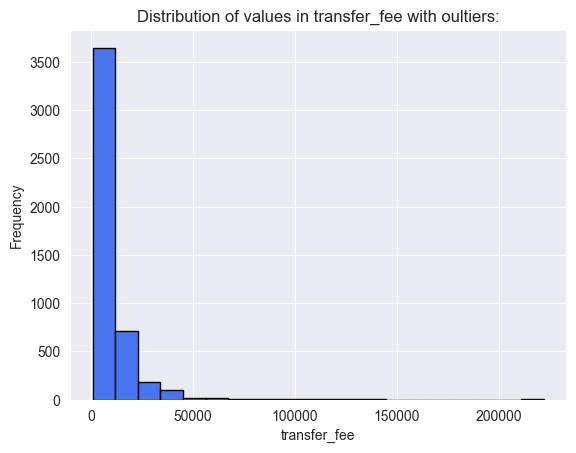

Mean value of 'transfer_fee' with oultiers: 9447.586170212766
Median value of 'transfer_fee' with oultiers: 6500.0
Variance value of 'transfer_fee' with oultiers: 108922804.64683002
1st quartile value of 'transfer_fee' with oultiers: 4000.0
3rd quartile value of 'transfer_fee' with oultiers: 10820.0


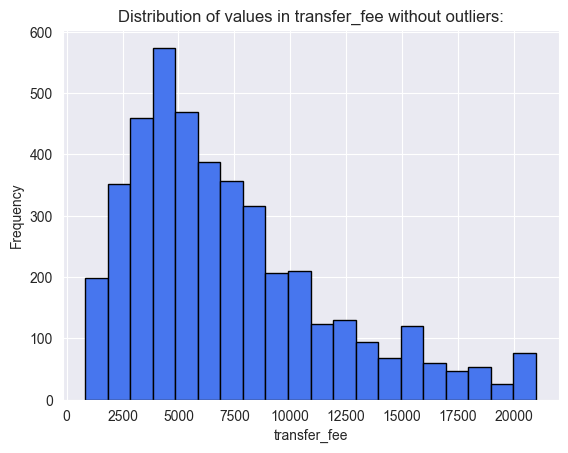

Mean value of 'transfer_fee' without outliers: 7136.066389081656
Median value of 'transfer_fee' without outliers: 6000.0
Variance value of 'transfer_fee' without outliers: 19499766.651387077
1st quartile value of 'transfer_fee' without outliers: 4000.0
3rd quartile value of 'transfer_fee' without outliers: 9200.0


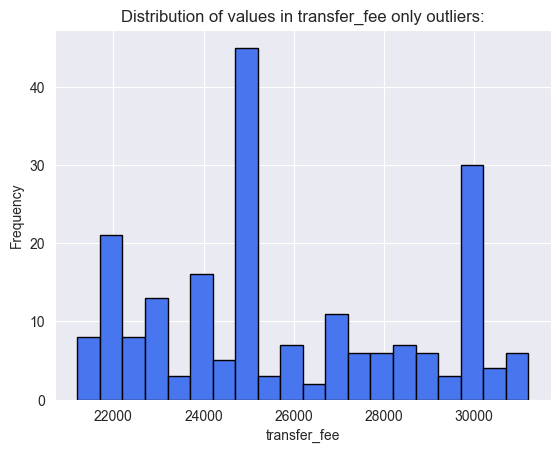

Mean value of 'transfer_fee' only outliers: 25810.428571428572
Median value of 'transfer_fee' only outliers: 25000.0
Variance value of 'transfer_fee' only outliers: 8347978.387755101
1st quartile value of 'transfer_fee' only outliers: 23515.0
3rd quartile value of 'transfer_fee' only outliers: 28475.0


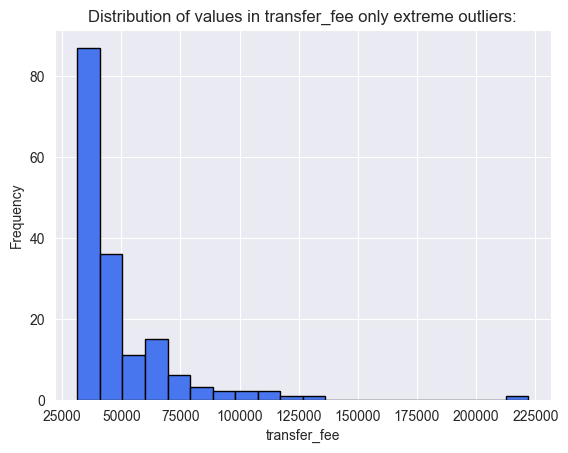

Mean value of 'transfer_fee' only extreme outliers: 48708.08383233533
Median value of 'transfer_fee' only extreme outliers: 40000.0
Variance value of 'transfer_fee' only extreme outliers: 533836934.05285245
1st quartile value of 'transfer_fee' only extreme outliers: 36075.0
3rd quartile value of 'transfer_fee' only extreme outliers: 52790.0


In [31]:
get_hist(df,"transfer_fee", "with oultiers")
df_without_outliers = df[~df.isin(pd.concat([outliers, ext_outliers]))].dropna()
get_hist(df_without_outliers,"transfer_fee", "without outliers")
get_hist(outliers,"transfer_fee" ,"only outliers")
get_hist(ext_outliers,"transfer_fee" ,"only extreme outliers")

Distribution of age approx. normally distributed with mean= 24.34 and var = 10.3. 
With IQR being 22 - 27, we can say that 50 % of the most expensive players are between 22 - 27 years old.

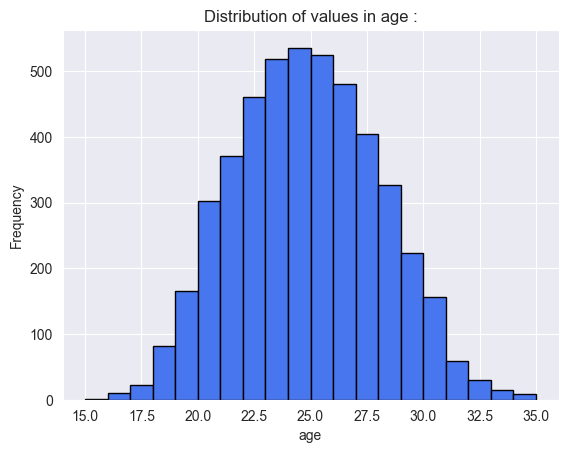

Mean value of 'age' : 24.34404255319149
Median value of 'age' : 24.0
Variance value of 'age' : 10.309932593933906
1st quartile value of 'age' : 22.0
3rd quartile value of 'age' : 27.0


In [32]:
get_hist(df, "age")

Looking at statistics of transfers: 
- 9.85 % to different league in the same country 
- 31.85 % within the same league
- 57.6 % to different country 

From this we can assume that players who do not play the in the top league in their country do not get transferred for egregious amount of money that often (~10% of cases). On the other hand, inter-country transfers tend to be really expensive, as are within-league. Let us dive deeper into the nature of those transfers.

**Cases of same league, different country are caused by same names of leagues across countries. E.g. "premier liga" is the name of the highest league in both Russia and Ukraine.**

In [33]:
print(f"Total amount of transfers to a different league in the same country:  {df.loc[(df['new_league'] != df['original_league']) & (df['new_country'] == df['original_country'])].shape[0]}, {round(df.loc[(df['new_league'] != df['original_league']) & (df['new_country'] == df['original_country'])].shape[0]/df.shape[0]*100, 2)}% of cases.")
print(f"Total amount of transfers within the same league in the same country:  {df.loc[(df['new_league'] == df['original_league']) & (df['new_country'] == df['original_country'])].shape[0]}, {round(df.loc[(df['new_league'] == df['original_league']) & (df['new_country'] == df['original_country'])].shape[0] / df.shape[0] * 100, 2)}% of cases.")
print(f"Total amount of transfers to a different league in a different country:  {df.loc[(df['new_league'] != df['original_league']) & (df['new_country'] != df['original_country'])].shape[0]}, {round(df.loc[(df['new_league'] != df['original_league']) & (df['new_country'] != df['original_country'])].shape[0]/df.shape[0]*100, 2)}% of cases.")

Total amount of transfers to a different league in the same country:  468, 9.96% of cases.
Total amount of transfers within the same league in the same country:  1503, 31.98% of cases.
Total amount of transfers to a different league in a different country:  2702, 57.49% of cases.


**Different league, same country**
- we can see that the most popular transfer among the high-profile transfers is from championship to premier league - 2nd highest and 1st highest football leagues in England.
- second most popular is analogical for serie a and serie b in Italy

In [34]:
df_filt = df.loc[(df["new_league"] != df["original_league"]) & (df["new_country"] == df["original_country"])]
df_filt.groupby(["original_league","new_league"]).size().nlargest(10)

original_league  new_league    
championship     premier league    142
serie b          serie a            74
first division   premier league     42
2.bundesliga     1.bundesliga       29
laliga2          laliga             28
ligue 2          ligue 1            28
premier league   championship       25
england          premier league     17
serie a          serie b            13
premier league   england            10
dtype: int64

**Same league, same country**
- Intra-Premier League transfers and intra-Serie A transfers are dominating the charts with 362 and 359 cases. 
- Ligue 1 from France, LaLiga from Spain and 1.Bundesliga are coming in second with all aroung 140 transfers.

In [35]:
df_filt = df.loc[(df["new_league"] == df["original_league"]) & (df["new_country"] == df["original_country"])]
df_filt.groupby(["original_league","new_league"]).size().nlargest(10)

original_league  new_league    
premier league   premier league    362
serie a          serie a           359
ligue 1          ligue 1           159
laliga           laliga            147
1.bundesliga     1.bundesliga      136
premier liga     premier liga       68
eredivisie       eredivisie         49
süper lig        süper lig          39
super league     super league       29
championship     championship       23
dtype: int64

**Different league, different country**
- Premier league is a total sweeper when it comes to extracting expensive players from teams located abroad.
- Most (expensive) players coming into premier league were from Ligue 1, LaLiga, Serie A and Eredivisie (Dutch league)
- On the fifth spot come transfers from Premier League to LaLiga

In [36]:
df_filt = df.loc[(df["new_league"] != df["original_league"]) & (df["new_country"] != df["original_country"])]
df_filt.groupby(["original_league","new_league"]).size().nlargest(10)

original_league  new_league    
ligue 1          premier league    125
laliga           premier league     98
serie a          premier league     73
eredivisie       premier league     65
premier league   laliga             62
laliga           serie a            61
1.bundesliga     premier league     48
série a          premier liga       47
ligue 1          laliga             44
serie a          laliga             40
dtype: int64

As for the total number of money spent on the high-level transfers, both the expenditure and money gains are topped by Premier League, whose teams paid out during the years 2000-2018 14 695 400 000 eur to other teams. Teams in Premier League received 7 248 510 000 eur. We can then assume that Premier League teams most often than not pay for their talent, rather than sell it to other leagues.

An example from the opposite side is Portuguese Liga Nos, whose teams spent in total 799 560 000 eur on purchasing top talent and gained 2 231 680 000 eur in exchange for selling their talent. 

In [37]:
display(df.groupby("new_league")["transfer_fee"].sum().sort_values(ascending=False).head(20))
display(df.groupby("original_league")["transfer_fee"].sum().sort_values(ascending=False).head(20))

new_league
premier league          14695400.0
serie a                  7535220.0
laliga                   6680360.0
ligue 1                  3682720.0
1.bundesliga             3599645.0
premier liga             2213860.0
super league             1190280.0
liga nos                  799560.0
süper lig                 682130.0
eredivisie                545000.0
championship              520420.0
série a                   308490.0
liga mx clausura          169360.0
uae gulf league           151500.0
stars league              128950.0
qatar                     115850.0
scotland                  114530.0
united arab emirates       93050.0
professional league        89840.0
premiership                89380.0
Name: transfer_fee, dtype: float64

original_league
premier league        7248510.0
serie a               7083980.0
laliga                5533860.0
ligue 1               4396890.0
1.bundesliga          3062960.0
liga nos              2231680.0
série a               1710610.0
premier liga          1675170.0
eredivisie            1559080.0
championship          1551260.0
super league           814250.0
serie b                641620.0
jupiler pro league     607790.0
süper lig              553350.0
torneo final           508650.0
brazil                 449770.0
laliga2                405150.0
primera división       376330.0
argentina              363660.0
liga mx clausura       271070.0
Name: transfer_fee, dtype: float64

More than 25 % of the 250 most expensive football transfers recorded included players playing the 'centre forward' position, then 'centre back' at rougly 15 %, followed by 'central midfield', 'attacking midfield' and 'defensive midfield' at approx 10  %, 9% and 9% respectively. Other positions see a significant dropoff. 'forward', 'defender', 'sweeper' and 'midfielder' see little to no presence in the most exclusive 250. 

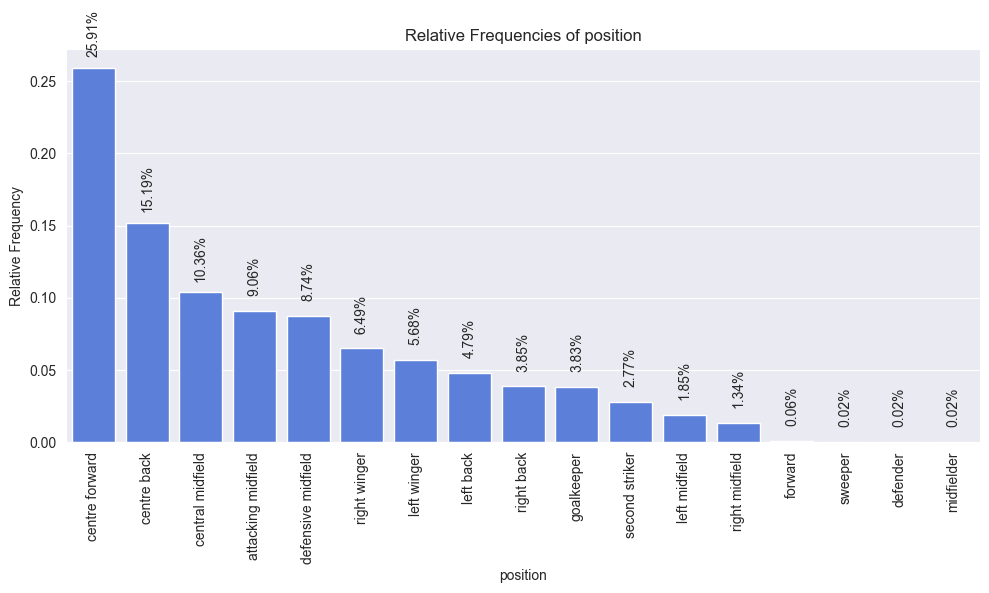

In [38]:
get_relative_freq_categorical(df,"position")

As there is more than plenty of teams and leagues, let's have a look at our added variable country. Analyzing this could give us more comprehensive look into what country's market is the best for high-profile transfers and could be a good intermediate step between analyzing leagues as it could lead us into countries with high amount of expensive transfers.

Looking at the relative frequency plot of new_country in the dataset of transfers, which symbolises the country where the player's new team is based in, we can see that England takes over with 28.70 %, followed by Italy with 16.36 %, Spain at 11.28 %, Germany and France at 9.11 % and 8.55 % respectively. After those leagues, it is only Russia with 5.04 % that clings over 5 %. This can be interpreted as such: In 28.7 % cases from the top 250 most expensive football buyouts from each year ranging from 2000-2018, the team pourchasing the player was based in England. 
This gives us an insight into how strong of a football market England is and how their teams do not fear to go to extensive lengths when purchasing new additions to their teams.


The next plot shows us the evolution on the market over time - at least for the market represented by our limited dataset. I decided to plot the top 6 who all had more than 5% share on the global market. England dominates high-end transfers for all years, the only year it just barely wasn't the top1 market for the most expensive players was 2018, when Italy, with its steady rise from  2014 came in first. In this plot we can also see the decline in high-level purchases by Russian teams, possibly corellating with the sanctions imposed by the EU and USA because of Russia's unlawful 2014 annexation of Ukrainian Crimea. 

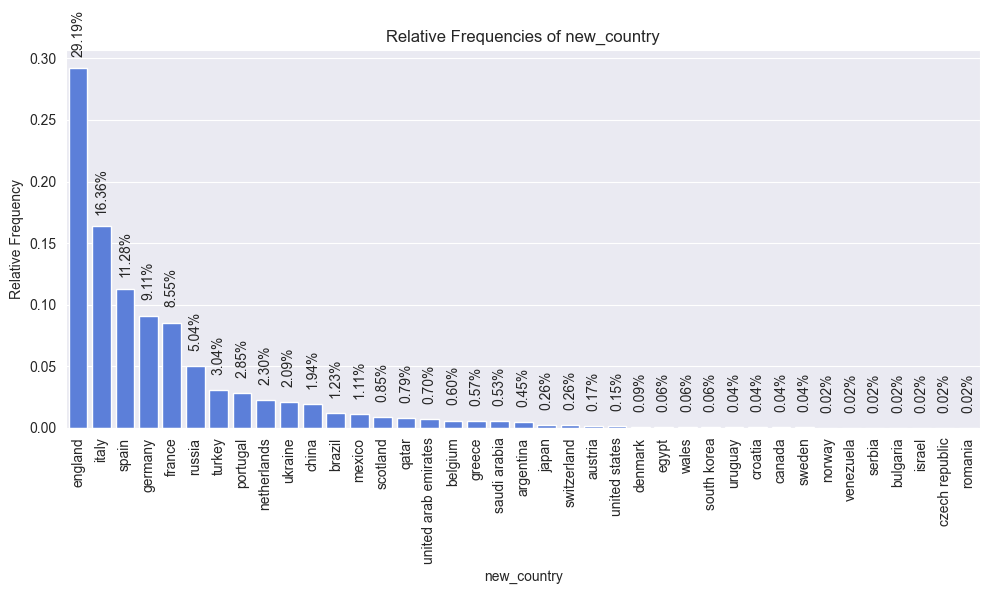

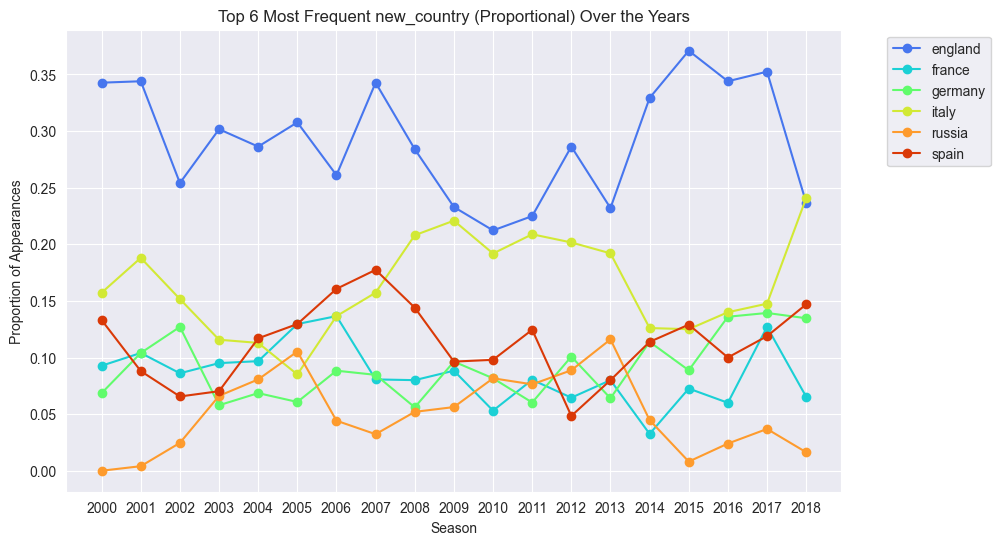

In [39]:
get_relative_freq_categorical(df, "new_country")
plot_popular_destinations(df, "new_country", 6)

Interesting thing to see is also that the share of incoming transfers in Italy and England seem to have inverse relationship -> High number of expensive transfers in one league means decrease in the other. This inverse relationship is worth noting and could do for an interesting exploration.

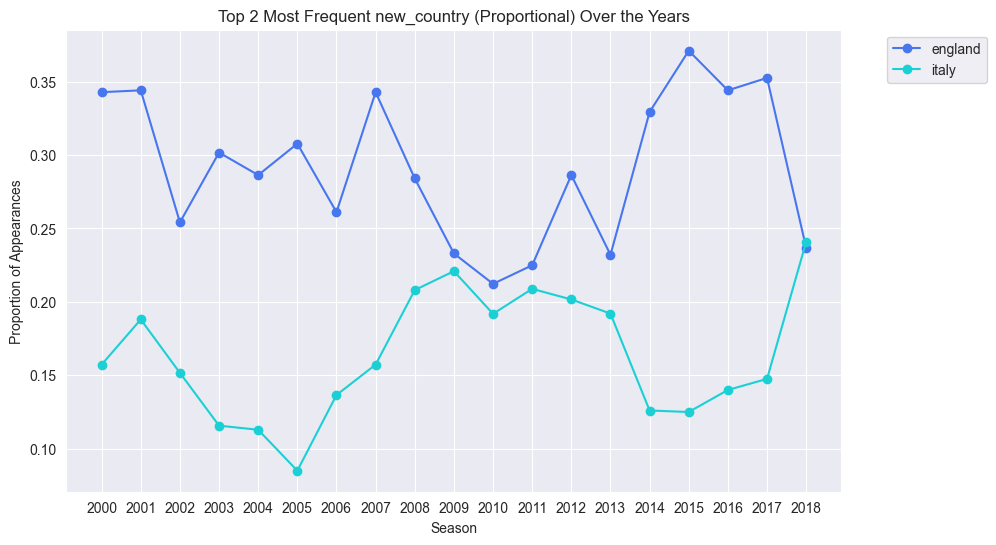

In [40]:
plot_popular_destinations(df, "new_country", 2)

While inpecting the relative frequencies of countries in the original_country column, we can see that England tops this chart as well, albeit with slightly less dominance.
Interpreting this plot could be tricky, as one could easily interpret this plot as being the country from which players leave the most. This is not the case. This plot only shows us the home country of most of the teams who agreed to sell their players to another team for a sum that is in top 250 in given year. In this category, Brazil has replaced Russia as the last country above 5 %. This means that while Brazil teams are able to produce top-class expensive players, they are most often than not headed outside Brazil.

In this plot we see a lot more variety in the countries, as talent playing in the 'lesser' countries, when it comes to football culture, tends to go to markets which are able to pay their expensive buyouts. 

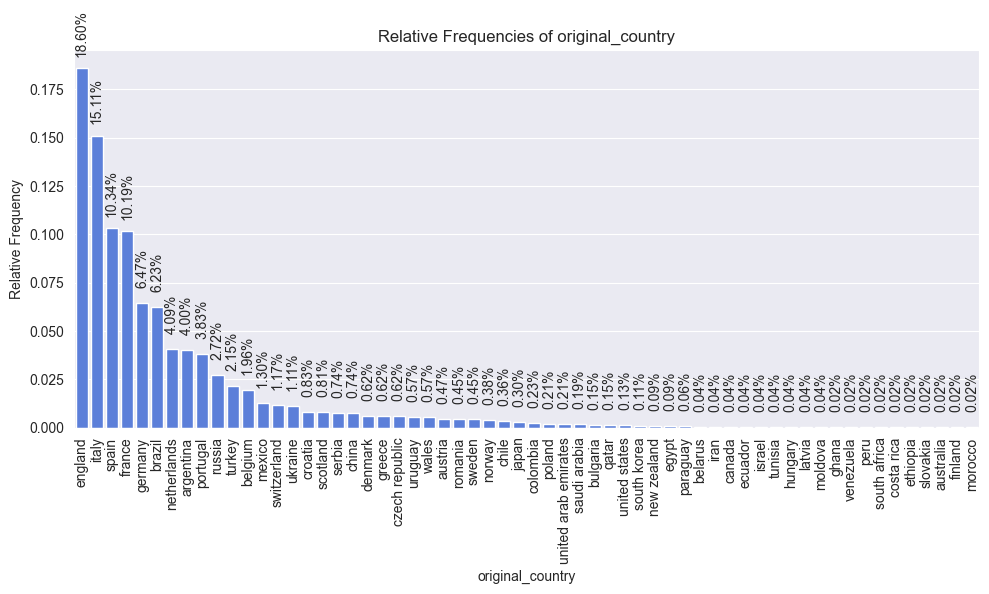

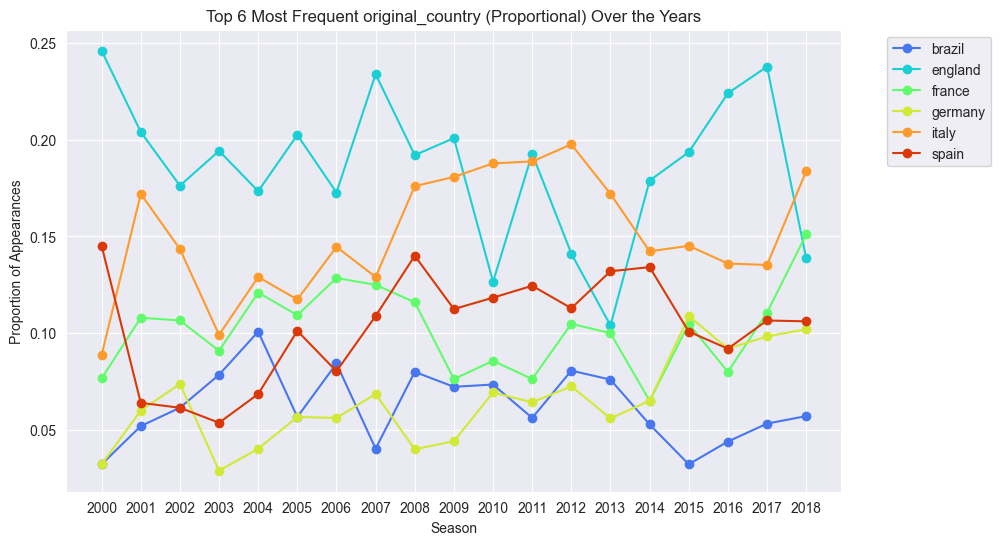

In [41]:
get_relative_freq_categorical(df, "original_country")
plot_popular_destinations(df, "original_country", 6)

Relative frequencies of new_league are looking similarly to new_country analysis from before, but show respective leagues. The chart is once again dominated by the English - the premier league teams account for 26.72 % of the top 250 purchases from the years 2000-2018.

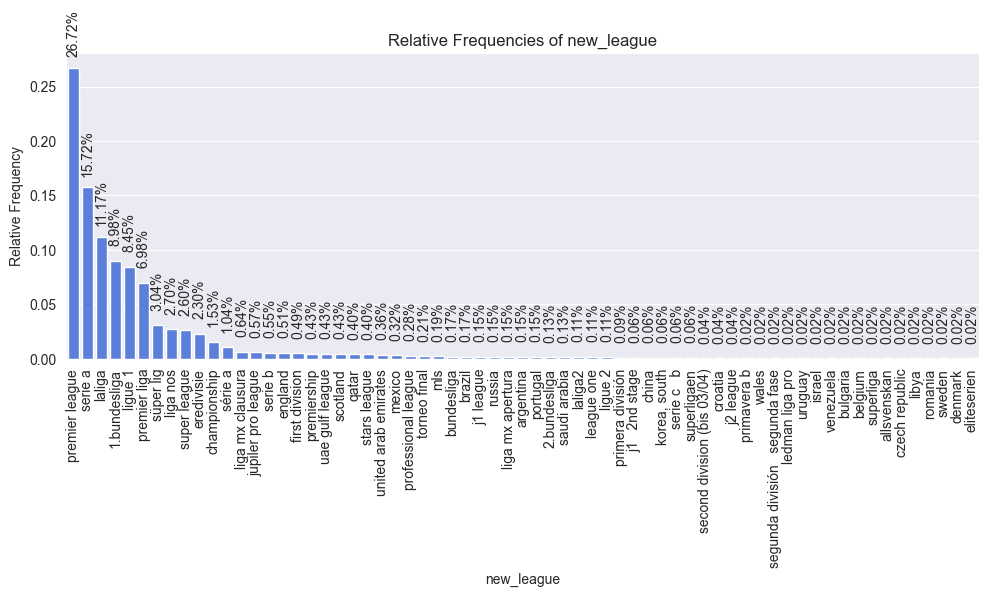

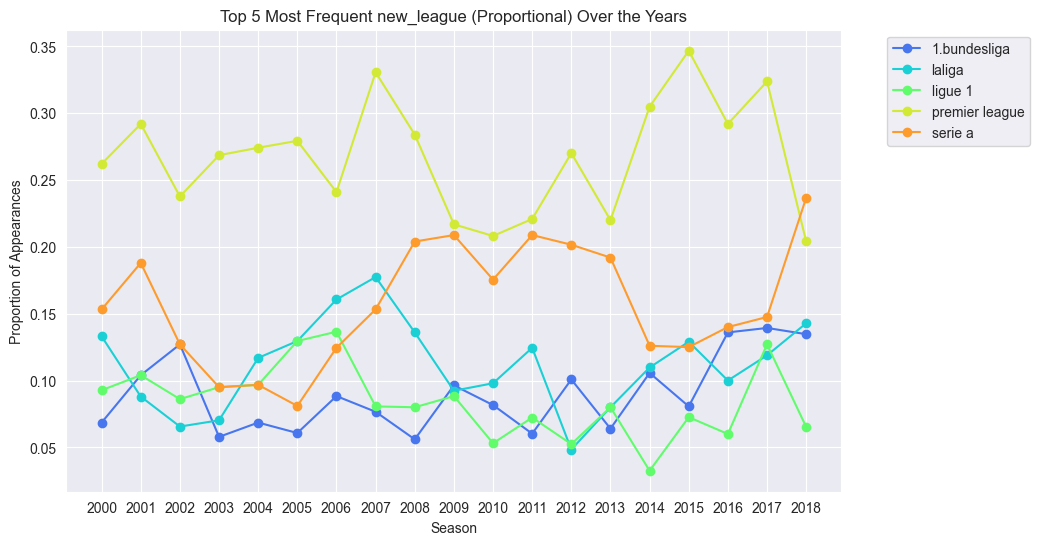

In [63]:
get_relative_freq_categorical(df, "new_league")
plot_popular_destinations(df, "new_league", 5)

Let's look into what position dominates the most demanded players in the years 2000-2018. As I am keeping quite a bit of outliers, I decided to stick with median as that will be robust enough for us. 
From this plot we can see that left winger position has the highest median price at 8 200 000 eur with 267 support from the dataset. 
On the other hand, centre forward position has the highest support in our dataset with 1218, but much lower median value of transfer at 6 800 000 eur.
Sweeper, forward, defender and midfielder are represented by units of transactions. As I have no knowledge of football, I will amount this to the unpopular nature of these roles, rather than redundancy with other names (e.g. forward being another name for other position)

Summary DataFrame:
                              Position  Median      Mean  Support
position                                                         
left winger                left winger  8200.0  12904.64      267
right winger              right winger  7500.0  11930.36      305
central midfield      central midfield  7000.0  10096.24      487
attacking midfield  attacking midfield  6950.0   9824.18      426
defensive midfield  defensive midfield  6900.0   8992.02      411
centre forward          centre forward  6800.0   9590.27     1218
centre back                centre back  6000.0   8448.59      714
second striker          second striker  6000.0   8790.15      130
right back                  right back  5900.0   8254.31      181
left back                    left back  5500.0   7718.93      225
goalkeeper                  goalkeeper  5500.0   7622.67      180
left midfield            left midfield  4700.0   6717.13       87
right midfield          right midfield  4500.0   7404.13 

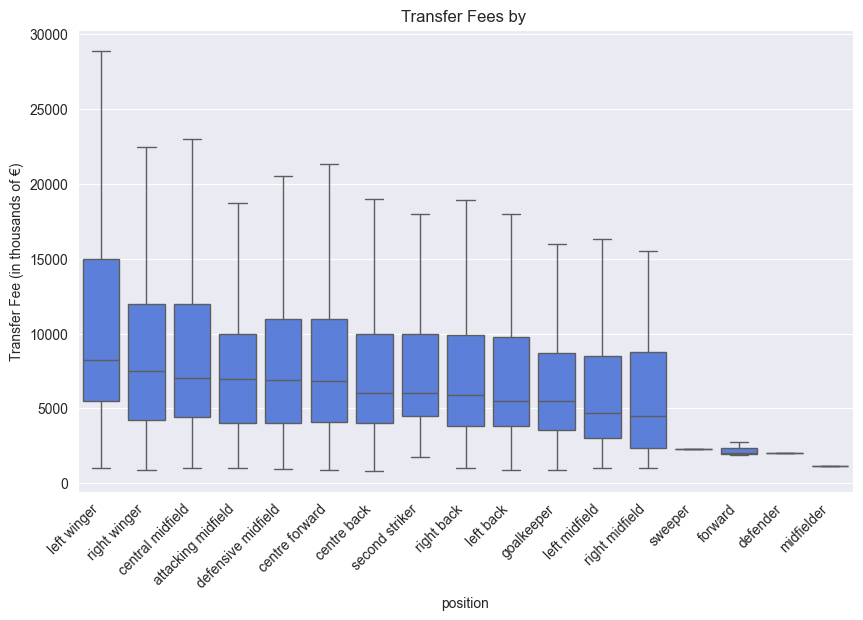

In [43]:
median_price_per_player(df, "position")

Another interesting thing to look at could be the evolution of mean transfer fee over time.
From this we can see that the highest median is in year 2017, lowest in the year 2003 with difference being astonishing. This could be due to inflation, more money being spent in the football industry or generally more competitive environment on the football player market. 

One thing to notice is the increasing variance (volatility) in transfer fees as the time progresses.

Summary DataFrame:
        Position   Median      Mean  Support
season                                      
2017        2017  13000.0  19459.75      244
2016        2016  12000.0  15919.68      250
2015        2015  10000.0  13773.83      248
2018        2018   9000.0  14023.14      245
2013        2013   8000.0  11514.88      250
2014        2014   7150.0  11090.28      246
2007        2007   6800.0   8656.21      248
2011        2011   6600.0   8575.22      249
2008        2008   6350.0   8494.88      250
2012        2012   6000.0   8677.74      248
2010        2010   6000.0   8174.45      245
2009        2009   5700.0   8758.11      249
2001        2001   5275.0   8308.32      250
2006        2006   4500.0   6196.14      249
2000        2000   4500.0   7511.69      248
2005        2005   3600.0   5441.58      247
2004        2004   3500.0   5621.73      248
2002        2002   2555.0   4697.44      244
2003        2003   2500.0   4580.62      242


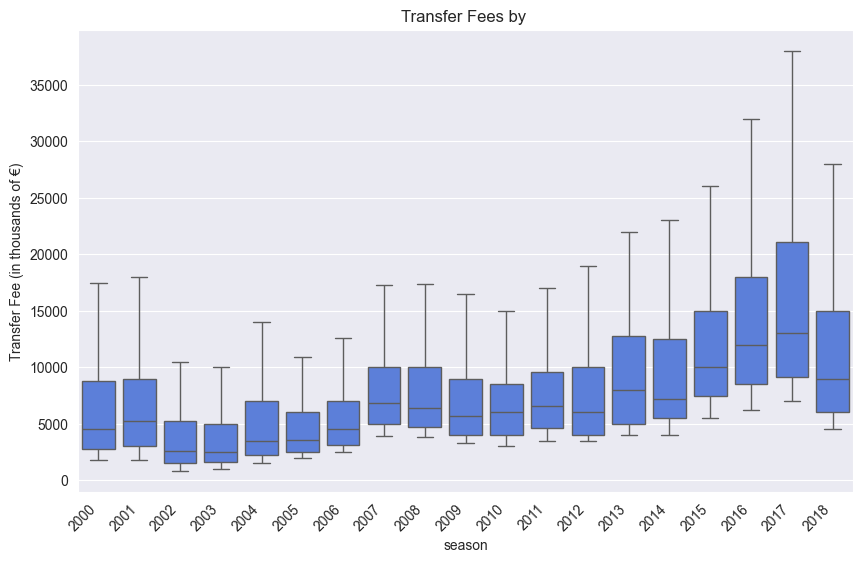

In [44]:
median_price_per_player(df, "season")

Looking closely on the median prices by age, we can see that the highest median price is for 27 year old players with 7 225 000 median price per player. 27 year old footballers have the widest IQR from all the players. Players 31 and older rarely make it to the top 250 most expensive buyouts and if they do, their transfer fees are among the lowest, on par with young players under 18, who get really similar statistics. 

Summary DataFrame:
     Position  Median      Mean  Support
age                                     
27         27  7225.0  10638.56      404
24         24  7000.0  10088.75      536
19         19  7000.0   9485.82      165
20         20  7000.0   9022.65      302
26         26  7000.0   9419.09      481
18         18  6550.0   9070.85       82
25         25  6500.0   9899.10      525
22         22  6400.0   8916.53      461
23         23  6380.0   9714.99      519
28         28  6250.0   9169.85      327
29         29  6100.0   9674.98      223
21         21  6000.0   9240.58      371
31         31  5700.0   7143.90       59
30         30  5480.0   7462.36      157
17         17  5000.0   6245.22       23
16         16  4850.0   8070.00       10
32         32  4500.0   5070.00       30
35         35  3875.0   3762.50        4
33         33  3500.0  13040.00       15
15         15  3200.0   3200.00        1
34         34  3000.0   3280.00        5


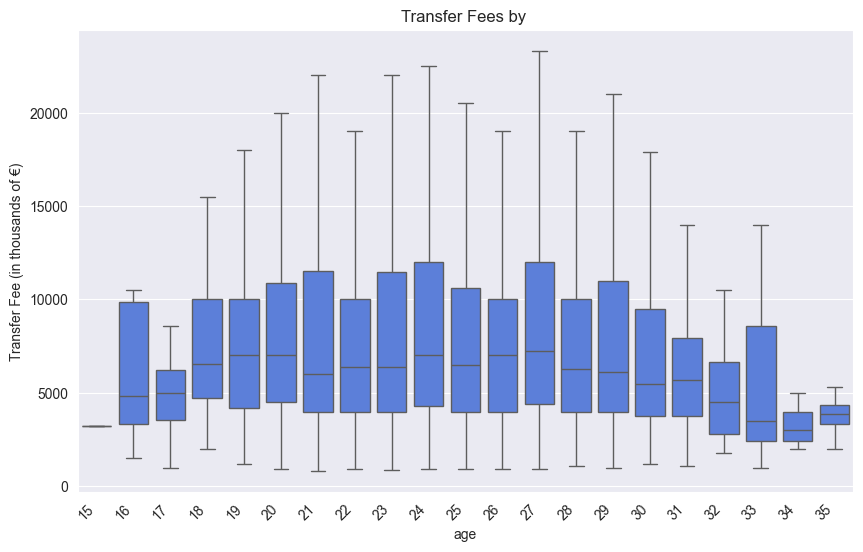

In [45]:
median_price_per_player(df, "age")

When looking the median price of players in respect to the country of the club they are being transferred to, it is a bit tricky to interpet the results. We can see tha Uruguay and China top this statistics by a wide margin, however out of 4700 of the highest transfers, these countries account only for 2 + 91 occurences. So while teams from these countries have high median prices per transfer in this dataset, they do not have many such cases. China has higher median and mean than all of the big players except Spain. 

From the "big players", Spain tops this with median of 8 000 000 eur, followed by England with 7 570 000 eur. 

Summary DataFrame:
                                  Position  Median      Mean  Support
new_country                                                          
uruguay                            uruguay  8875.0   8875.00        2
china                                china  8500.0  11949.78       91
spain                                spain  8000.0  12658.04      530
england                            england  7675.0  11171.62     1372
canada                              canada  7350.0   7350.00        2
italy                                italy  7100.0   9928.10      769
germany                            germany  6500.0   8499.17      428
united states                united states  6360.0   6962.86        7
qatar                                qatar  6300.0   6562.16       37
saudi arabia                  saudi arabia  6000.0   5481.60       25
united arab emirates  united arab emirates  6000.0   6937.88       33
france                              france  6000.0   9239.35      402
p

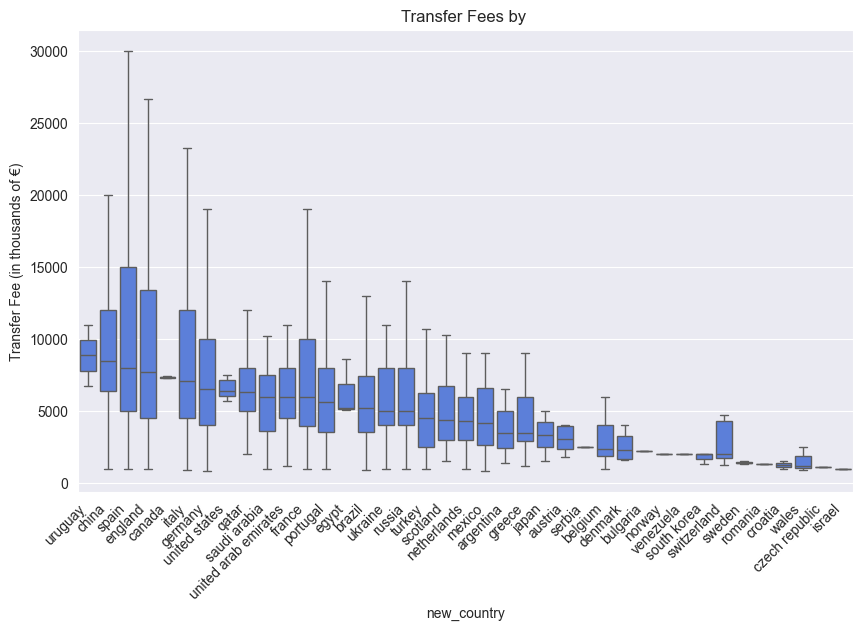

In [46]:
median_price_per_player(df, "new_country")

Analyzing the teams who paid the most median price per player yields expected results - all teams are either English, Spanish, French or Italian with an English team - Man Utd. with the highest median price. 

Looking at teams who **sold** their players for the highest mean value is more intereting - this chart is topped by Benfica and FC Porto, both Portuguese teams, who come at 15 000 000 eur and 14 000 000 eur. Then comes AS Roma and Monaco. Monaco has the highest mean price, almost double of the median. This is most likely caused by some extreme outliers present. 

**NOTE: I subset only the 20 most frequent teams as going through all of them would be of no use**

Summary DataFrame:
                        Position   Median      Mean  Support
new_team                                                    
man utd                  man utd  18000.0  23036.31       65
fc barcelona        fc barcelona  17000.0  23900.57       70
real madrid          real madrid  16000.0  22408.67       75
chelsea                  chelsea  15500.0  18965.10       96
man city                man city  13000.0  19154.47       94
juventus                juventus  12000.0  16907.36       87
arsenal                  arsenal  12000.0  14738.69       61
ac milan                ac milan  10500.0  13843.38       68
liverpool              liverpool  10500.0  16616.71       85
inter                      inter  10200.0  12398.87       97
spurs                      spurs   9500.0  11015.05       93
paris sg                paris sg   9050.0  19314.85       66
atlético madrid  atlético madrid   9000.0  13316.09       69
monaco                    monaco   9000.0  11239.51       61
as ro

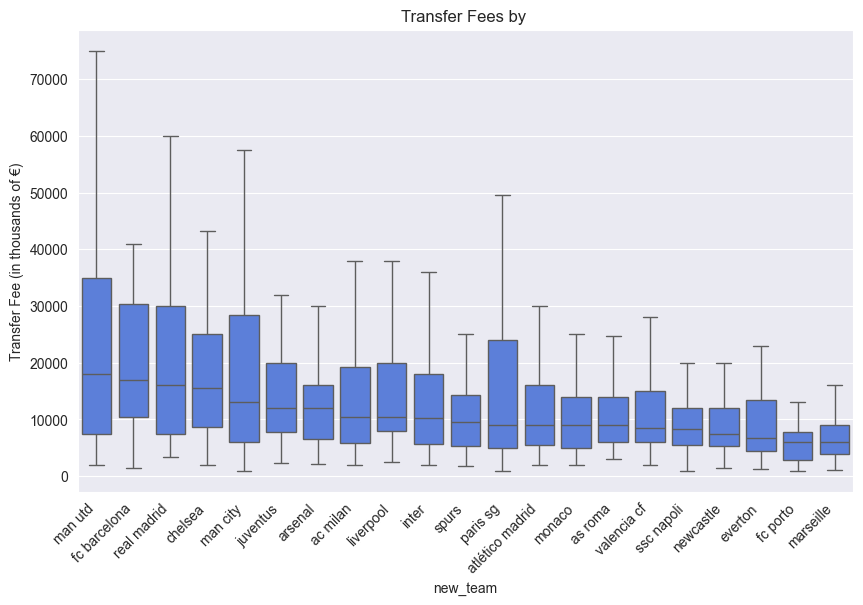

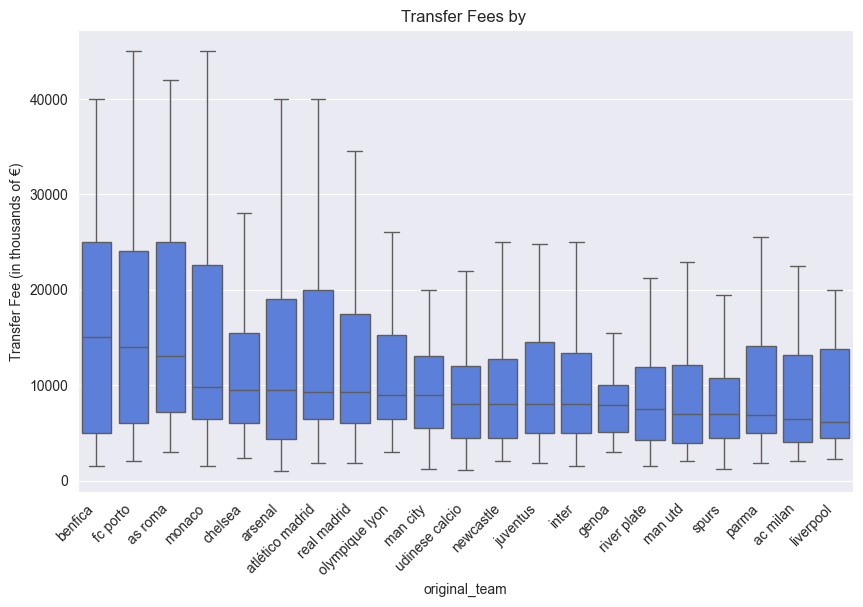

In [47]:
median_price_per_player(df[df["new_team"].isin(df["new_team"].value_counts()[:21].index.tolist())], "new_team")
median_price_per_player(df[df["original_team"].isin(df["original_team"].value_counts()[:21].index.tolist())], "original_team")

Lets look at the cumulative teams' expenditure. 

In 18 years, the highest-paying team has been Chelsea with 1 820 650 000 eur paid for transfer fees. This is only for the most expensive ones, the real number, including the transfers that didn't make the cut into the dataset will be much higher I assume. 

On the other hand, the most profitable team has been Monaco, who grossed out 948 170 000 eur for transferring their most expensive players to other teams. FC Porto comes in second with Real Madrid third.

In [48]:
display(df.groupby("new_team")["transfer_fee"].sum().sort_values(ascending=False).head(20))
display(df.groupby("original_team")["transfer_fee"].sum().sort_values(ascending=False).head(20))

new_team
chelsea            1820650.0
man city           1800520.0
real madrid        1680650.0
fc barcelona       1673040.0
man utd            1497360.0
juventus           1470940.0
liverpool          1412420.0
paris sg           1274780.0
inter              1202690.0
spurs              1024400.0
ac milan            941350.0
atlético madrid     918810.0
arsenal             899060.0
as roma             826380.0
bayern munich       812350.0
monaco              685610.0
everton             682680.0
valencia cf         638650.0
ssc napoli          602450.0
bor. dortmund       557040.0
Name: transfer_fee, dtype: float64

original_team
monaco             948170.0
fc porto           917550.0
real madrid        891400.0
chelsea            839530.0
liverpool          798410.0
juventus           797980.0
benfica            785750.0
inter              785280.0
fc barcelona       752100.0
atlético madrid    734400.0
as roma            724800.0
spurs              699000.0
valencia cf        599650.0
bor. dortmund      580350.0
sevilla fc         564600.0
parma              554320.0
olympique lyon     535400.0
arsenal            530170.0
man utd            527570.0
ac milan           489350.0
Name: transfer_fee, dtype: float64

## 2. The extreme extremes

Let's explore the extreme outliers - players that were traded for the highest sums and are considered extreme outliers in comparison to other (already top 250 most expensive from each year) players. 

We have 167 players considered extreme outliers by lying outside the 3*IQR boundaries. 

Their mean transfer fee is 48 708 083 eur, with median being 40 000 000 eur. That's quite a lot.

Looking at the distribution, we can see that more of the extremely expensive transfers happened from 2012 onward. This could be generally due to inflation, more money being spent in the football industry or the market becoming more competitive and teams waging "price wars" between each other for the superstar players. Or just coincidence.

In [49]:
display(ext_outliers.describe())
display(np.median(ext_outliers["transfer_fee"]))
display(np.median(df["transfer_fee"]))

,age,season,estimated_value,transfer_fee
count,167.000000,167.000000,146.000000,167.000000
mean,24.407186,2012.850299,34234.931507,48708.083832
std,2.955810,5.254520,18369.039141,23174.400083
min,18.000000,2000.000000,2500.000000,31400.000000
25%,22.000000,2011.000000,23000.000000,36075.000000
50%,24.000000,2015.000000,30000.000000,40000.000000
75%,27.000000,2017.000000,45000.000000,52790.000000
max,33.000000,2018.000000,120000.000000,222000.000000


40000.0

6500.0

The largest transfer fee was paid for Neymar in 2017 when transferring from FC Barcelona to PSG. It was a whopping 222 000 000 eur. 
Second largest was Kylian Mbappé from Monaco to PSG for 135 000 000 eur. 

In [50]:
ext_outliers.sort_values(by="transfer_fee", ascending=False)

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee,new_country,original_country
4211,neymar,left winger,25,fc barcelona,laliga,paris sg,ligue 1,2017,100000.0,222000.0,france,spain
4455,kylian mbappé,right winger,19,monaco,ligue 1,paris sg,ligue 1,2018,120000.0,135000.0,france,france
4212,philippe coutinho,attacking midfield,25,liverpool,premier league,fc barcelona,laliga,2017,90000.0,125000.0,spain,england
4456,cristiano ronaldo,centre forward,33,real madrid,laliga,juventus,serie a,2018,100000.0,117000.0,italy,spain
4213,ousmane dembélé,right winger,20,bor. dortmund,1.bundesliga,fc barcelona,laliga,2017,33000.0,115000.0,spain,germany
...,...,...,...,...,...,...,...,...,...,...,...,...
2976,oscar,attacking midfield,20,internacional,série a,chelsea,premier league,2012,20000.0,32000.0,england,brazil
3730,danilo,right back,23,fc porto,liga nos,real madrid,laliga,2015,25000.0,31500.0,spain,portugal
1233,shaun wright phillips,right winger,23,man city,premier league,chelsea,premier league,2005,9500.0,31500.0,england,england
1730,anderson,central midfield,19,fc porto,liga nos,man utd,premier league,2007,25000.0,31500.0,england,portugal


Neymar and the whole top 6 most expensive transfers are considered extreme outliers even in the dataset limited to only extreme outliers. 

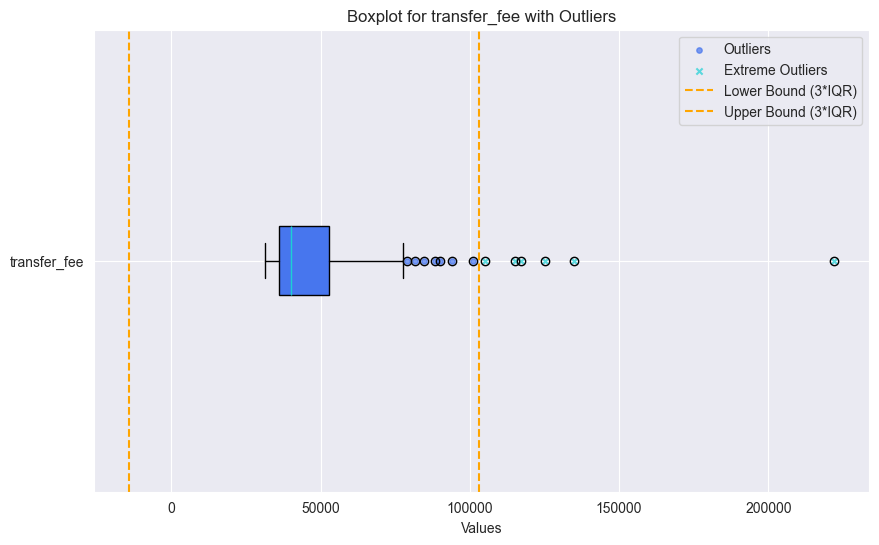

(                   name        position  age original_team original_league  \
 2226  cristiano ronaldo  centre forward   24       man utd  premier league   
 3217        gareth bale    right winger   24         spurs  premier league   
 3218             neymar     left winger   21     santos fc         série a   
 3467        luis suárez  centre forward   27     liverpool  premier league   
 3962    gonzalo higuaín  centre forward   28    ssc napoli         serie a   
 4214      romelu lukaku  centre forward   24       everton  premier league   
 4215    virgil van dijk     centre back   26   southampton  premier league   
 
           new_team      new_league  season  estimated_value  transfer_fee  \
 2226   real madrid          laliga    2009          60000.0       94000.0   
 3217   real madrid          laliga    2013          65000.0      101000.0   
 3218  fc barcelona          laliga    2013          50000.0       88200.0   
 3467  fc barcelona          laliga    2014          5

In [51]:
get_outliers_iqr(ext_outliers, "transfer_fee") 

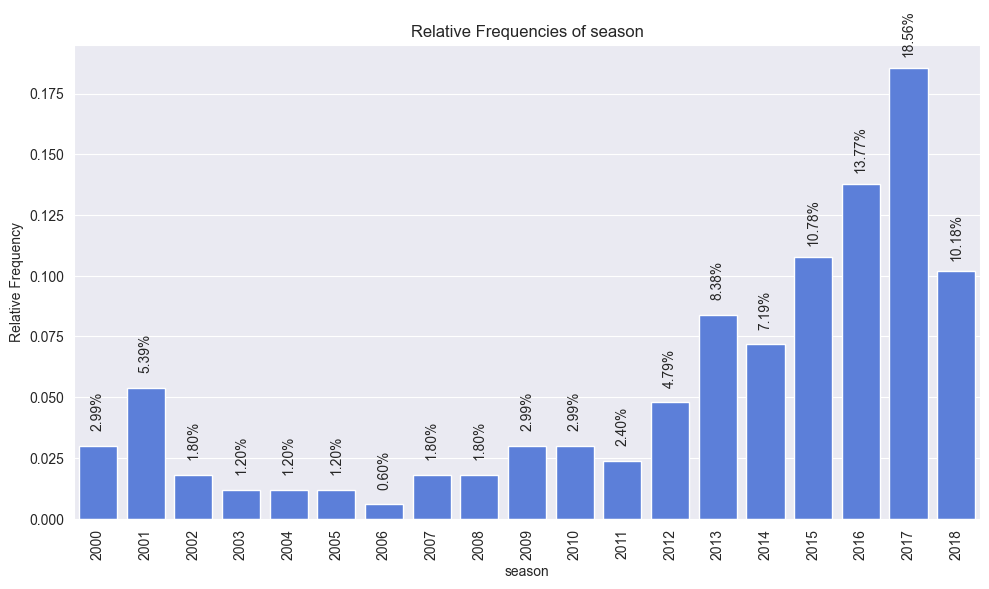

In [52]:
get_relative_freq_categorical(ext_outliers, "season")

Looking at the distributions of transfers, the total domination of purchases by teams from Premier League is apparent.

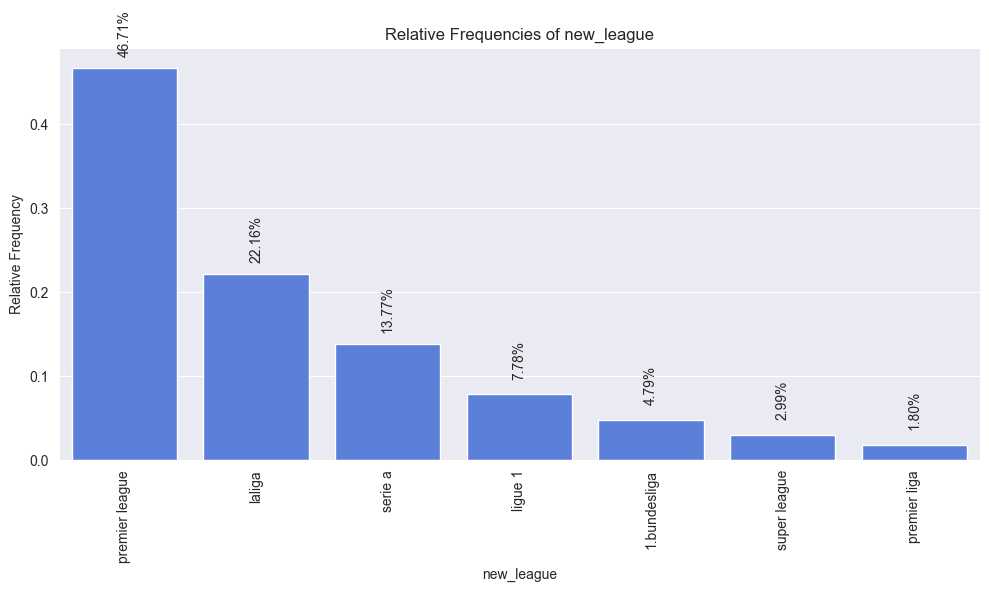

In [53]:
get_relative_freq_categorical(ext_outliers, "new_league")

Age distribution doesn't violate too much from the original. 

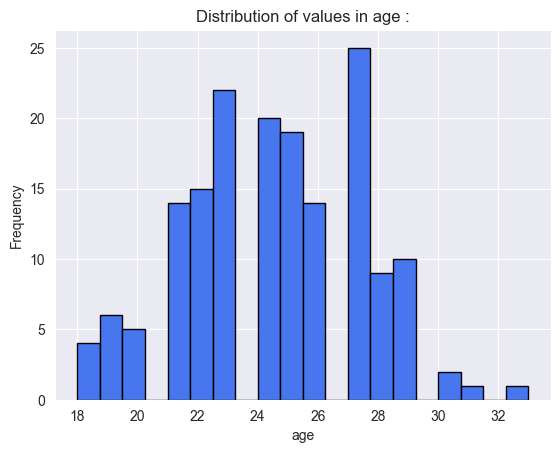

Mean value of 'age' : 24.407185628742514
Median value of 'age' : 24.0
Variance value of 'age' : 8.684499264943168
1st quartile value of 'age' : 22.0
3rd quartile value of 'age' : 27.0


In [54]:
get_hist(ext_outliers, "age")

Looking at statistics of transfers: 
- 0.6 % (1) to different league in the same country 
- 30.54 % (51) within the same league
- 67.07 % (112) to different country 

In [55]:
print(f"Total amount of transfers to a different league in the same country:  {ext_outliers.loc[(ext_outliers['new_league'] != ext_outliers['original_league']) & (ext_outliers['new_country'] == ext_outliers['original_country'])].shape[0]}, {round(ext_outliers.loc[(ext_outliers['new_league'] != ext_outliers['original_league']) & (ext_outliers['new_country'] == ext_outliers['original_country'])].shape[0]/ext_outliers.shape[0]*100, 2)}% of cases.")
print(f"Total amount of transfers within the same league in the same country:  {ext_outliers.loc[(ext_outliers['new_league'] == ext_outliers['original_league']) & (ext_outliers['new_country'] == ext_outliers['original_country'])].shape[0]}, {round(ext_outliers.loc[(ext_outliers['new_league'] == ext_outliers['original_league']) & (ext_outliers['new_country'] == ext_outliers['original_country'])].shape[0] / ext_outliers.shape[0] * 100, 2)}% of cases.")
print(f"Total amount of transfers to a different league in a different country:  {ext_outliers.loc[(ext_outliers['new_league'] != ext_outliers['original_league']) & (ext_outliers['new_country'] != ext_outliers['original_country'])].shape[0]}, {round(ext_outliers.loc[(ext_outliers['new_league'] != ext_outliers['original_league']) & (ext_outliers['new_country'] != ext_outliers['original_country'])].shape[0]/ext_outliers.shape[0]*100, 2)}% of cases.")

Total amount of transfers to a different league in the same country:  1, 0.6% of cases.
Total amount of transfers within the same league in the same country:  51, 30.54% of cases.
Total amount of transfers to a different league in a different country:  112, 67.07% of cases.


Looking at the most popular destinatons team-wise, it is pretty even with Chelsea being the top buyer of expensive players in the years 2005 and 2006.It has only gotten more even as the time progressed.

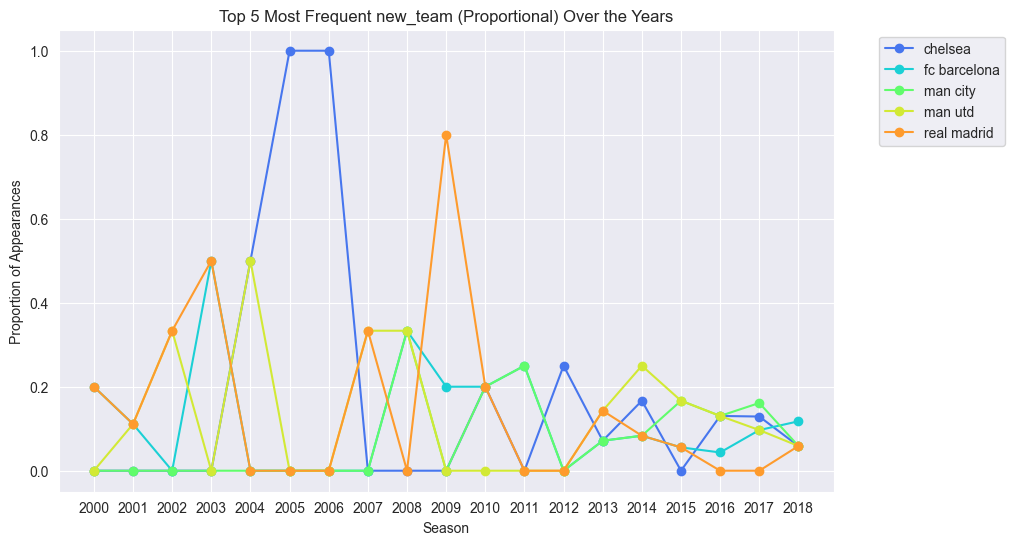

In [56]:
plot_popular_destinations(ext_outliers, "new_team", 5)

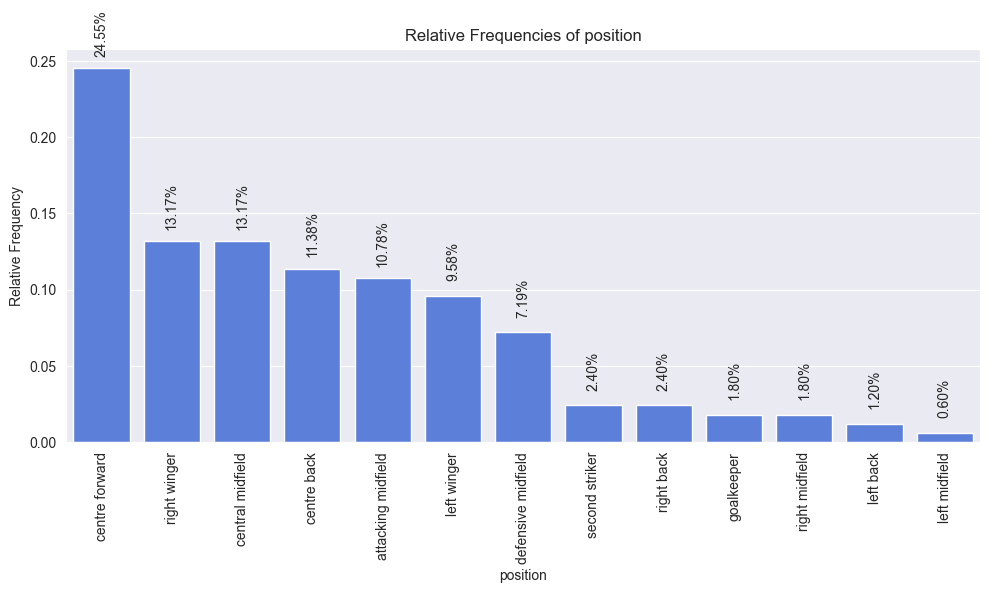

In [59]:
get_relative_freq_categorical(ext_outliers, "position")

# Conclusion
We need to be careful when making conclusions about teams in general - dataset is not randomly sampled, take everything said here in the context of the dataset being top purchases from each year.
### Teams & Countries

- Premier League is the most biggest league money-wise
- Portuguese teams turn the most profit in selling their players to other leagues
- Italian and English leagues compete with each other for top footballers - amount of transfers has inverse relationship
- Most of the transfers are to different countries, 57.49 %
- Premier League gets its talent from other prestigious leagues (LaLiga, Serie A, 1.Bundesliga, ...) 
- beggining of sanctions against Russia in 2014 is apparent in decrease of Russian presence on the expensive-player market
- Brazil is capable of producing talent, which it sources to other countries
- Median price per player has steadily increased and peaked in 2017. The volatility (IQR) has also increased over time.
- China seems like the "sleeping giant" when it comes to buying out expensive players - has the 2nd highest mean and median price per player with 91 purchases, which is a number to take into account. 
- Man Utd. pays the most for their players - median 18 000 000 eur and 23 036 310 eur mean
- Benfica and Porto are the best at selling their players
- Chelsea has spent the most money on players total. 1 820 650 000 eur.

### Players & Positions
- age is approx. normally distributed with mean 27, spanning from 15 to 35.
- centre-forward is the most traded position with occurence 25.91 %. 
- defender, forward, sweeper and midfielder are among the least traded
- left-winger has the highest mean and median price
- the only players considered outliers by age were the ones aged 35 - 4 goalkeepers and 1 left midfield
- Players aged 27 have the highest median and mean transfer fee
- Players below 18 and over 30 have the lowest transfer fees 

### Extremely expensive players
- Neymar transfer from 2017 is considered extreme even among other extreme values
- most of the extremely expensive transfers occured from 2013 onward
- Premier league makes up for almost half of the cases, further proving its dominance on this niche market
- Position distribution is roughly the same as in regular expensive players